In [2]:
import gzip
import pickle 
import mplhep as hep
hep.style.use("CMS")
import matplotlib
matplotlib.rc('font', size=15)
import numpy as np
import torch 
import pandas as pd
import numpy as np
import plotly.express as px
import sys
sys.path.append("/afs/cern.ch/work/m/mgarciam/private/mlpf/")
from sklearn.cluster import DBSCAN, HDBSCAN
from torch_scatter import scatter_max, scatter_add, scatter_mean
from src.layers.inference_oc import get_clustering, obtain_intersection_values
from scipy.optimize import linear_sum_assignment
import numpy as np
import matplotlib.pyplot as plt

In [5]:
from src.utils.inference.pandas_helpers import open_mlpf_dataframe
list_all_df_hdb = []
path_hgcal = "/eos/user/m/mgarciam/datasets_mlpf/models_trained_CLD/eval_comp_drs/showers_df_evaluation/0_0_None_hdbscan_005_cc_ee_180225.pt"
sd_hgb_ee_005, matched_hgb = open_mlpf_dataframe(path_hgcal, False)
path_hgcal = "/eos/user/m/mgarciam/datasets_mlpf/models_trained_CLD/eval_comp_drs/showers_df_evaluation/0_0_None_pandora_005_cc_ee_180225.pt"
sd_pandora_ee_005, matched_hgbq1 = open_mlpf_dataframe(path_hgcal, False)
path_hgcal = "/eos/user/m/mgarciam/datasets_mlpf/models_trained_CLD/eval_comp_drs/showers_df_evaluation/0_0_None_hdbscan_001_cc_ee_180225.pt"
sd_hgb_ee_001, matched_hgb = open_mlpf_dataframe(path_hgcal, False)
path_hgcal = "/eos/user/m/mgarciam/datasets_mlpf/models_trained_CLD/eval_comp_drs/showers_df_evaluation/0_0_None_pandora_001_cc_ee_180225.pt"
sd_pandora_ee_001, matched_hgbq1 = open_mlpf_dataframe(path_hgcal, False)
path_hgcal = "/eos/user/m/mgarciam/datasets_mlpf/models_trained_CLD/eval_comp_drs/showers_df_evaluation/0_0_None_hdbscan_01_cc_180225.pt"
sd_hgb_ee_01, matched_hgb = open_mlpf_dataframe(path_hgcal, False)
path_hgcal = "/eos/user/m/mgarciam/datasets_mlpf/models_trained_CLD/eval_comp_drs/showers_df_evaluation/0_0_None_pandora_01_cc_180225.pt"
sd_pandora_ee_01, matched_hgbq1 = open_mlpf_dataframe(path_hgcal, False)

# path_hgcal = "/eos/user/m/mgarciam/datasets_mlpf/models_trained_CLD/eval_comp_drs/showers_df_evaluation/0_0_None_hdbscan_005_cc_180225.pt"
# sd_hgb_cc_005, matched_hgb = open_mlpf_dataframe(path_hgcal, False)
# path_hgcal = "/eos/user/m/mgarciam/datasets_mlpf/models_trained_CLD/eval_comp_drs/showers_df_evaluation/0_0_None_pandora_005_cc_180225.pt"
# sd_pandora_cc_005, matched_hgbq1 = open_mlpf_dataframe(path_hgcal, False)
path_hgcal = "/eos/user/m/mgarciam/datasets_mlpf/models_trained_CLD/eval_comp_drs/showers_df_evaluation/0_0_None_hdbscan_001_cc_180225.pt"
sd_hgb_cc_001, matched_hgb = open_mlpf_dataframe(path_hgcal, False)
path_hgcal = "/eos/user/m/mgarciam/datasets_mlpf/models_trained_CLD/eval_comp_drs/showers_df_evaluation/0_0_None_pandora_001_cc_180225.pt"
sd_pandora_cc_001, matched_hgbq1 = open_mlpf_dataframe(path_hgcal, False)
path_hgcal = "/eos/user/m/mgarciam/datasets_mlpf/models_trained_CLD/eval_comp_drs/showers_df_evaluation/0_0_None_hdbscan_01_cc_ee_180225.pt"
sd_hgb_cc_01, matched_hgb = open_mlpf_dataframe(path_hgcal, False)
path_hgcal = "/eos/user/m/mgarciam/datasets_mlpf/models_trained_CLD/eval_comp_drs/showers_df_evaluation/0_0_None_pandora_01_cc_ee_180225.pt"
sd_pandora_cc_01, matched_hgbq1 = open_mlpf_dataframe(path_hgcal, False)

In [7]:
labels_ee = ["005 ee", "001 ee", "01 ee", "001 cc", "01 cc"]
sd = [sd_hgb_ee_005,sd_hgb_ee_001, sd_hgb_ee_01,sd_hgb_cc_001, sd_hgb_cc_01]
sd_pandora = [sd_pandora_ee_005,sd_pandora_ee_001, sd_pandora_ee_01 ,sd_pandora_cc_001, sd_pandora_cc_01 ]
pid_ckeck = [11, 11, 11, 211, 211]
eff =[ ]
eff_pandora =[]
for i,dic  in enumerate(sd):
    eff_dic = len(dic[(np.abs(dic["pid"])==pid_ckeck[i])*(dic["true_showers_E"]>3)*(~np.isnan(dic["pred_showers_E"]))])/  len(dic[(np.abs(dic["pid"])==pid_ckeck[i])*(dic["true_showers_E"])>3])
    eff.append(eff_dic)
for i,dic  in enumerate(sd_pandora):
    eff_dic = len(dic[(np.abs(dic["pid"])==pid_ckeck[i])*(dic["true_showers_E"]>3)*(~np.isnan(dic["pred_showers_E"]))])/ len(dic[(np.abs(dic["pid"])==pid_ckeck[i])*(dic["true_showers_E"])>3])
    eff_pandora.append(eff_dic)

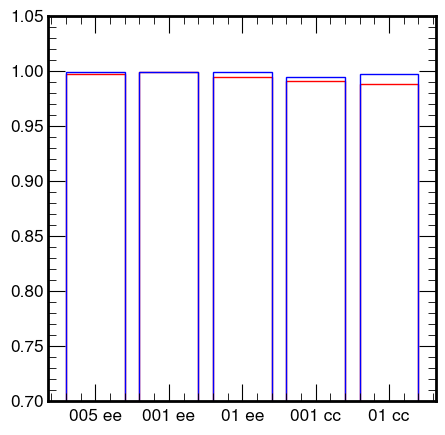

In [8]:
plt.figure(figsize=(5,5))
plt.bar(range(len(eff)), eff, align='center', fill=False,edgecolor="red")
plt.bar(range(len(eff_pandora)), eff_pandora, align='center', fill=False,edgecolor="blue")
plt.xticks(range(len(labels_ee)), labels_ee, size='small')
plt.ylim([0.7,1.05])
plt.show()

In [48]:
sd_pandora_ee_001[(np.abs(sd_pandora_ee_001["pid"])==11)*(sd_pandora_ee_001["true_showers_E"]>3)*(np.isnan(sd_pandora_ee_001["pred_showers_E"]))]

,true_showers_E,reco_showers_E,pred_showers_E,e_pred_and_truth,pandora_calibrated_E,pandora_calibrated_pfo,pandora_calibrated_pos,pandora_ref_pt,pid,pandora_pid,...,is_track_in_MC,distance_to_cluster_MC,vertex,ECAL_hits,HCAL_hits,ECAL_hits_true,HCAL_hits_true,delta_MC,true_pos,pid_4_class_true
3,4.534812,7.128200,NaN,NaN,NaN,NaN,"[nan, nan, nan]","[nan, nan, nan]",11.0,NaN,...,0,0.0,"[913.0114135742188, 420.4281005859375, -285.76...",NaN,NaN,180.0,0.0,0.015904,"[3.9686033725738525, 1.810156226158142, -1.240...",0.0
4,3.597209,11.687067,NaN,NaN,NaN,NaN,"[nan, nan, nan]","[nan, nan, nan]",-11.0,NaN,...,0,0.0,"[-533.3001098632812, -2058.228759765625, -90.4...",NaN,NaN,142.0,0.0,0.000299,"[-0.8933136463165283, -3.481126070022583, -0.1...",0.0


In [ ]:
sd_hgb_ee_001[(np.abs(sd_hgb_ee_001["pid"])==11)*(sd_hgb_ee_001["true_showers_E"]>3)*(np.isnan(sd_hgb_ee_001["pred_showers_E"]))]

: 